# Chemical Space, QSAR, and Model Pitfalls

## 90-Minute Laboratory — Teacher's Reference Solution

This notebook explores fundamental concepts in computational drug discovery:

1. **Chemical Space Exploration** — How molecules are represented and visualized
2. **Activity Cliffs** — Pairs of structurally similar molecules with drastically different activities
3. **QSAR Modeling** — Quantitative Structure-Activity Relationship prediction
4. **Dataset Splitting Strategies** — Why the choice of train/test split matters dramatically
5. **Model Explainability** — Understanding what drives predictions

### Dataset
We use the **SARS-CoV-2 Main Protease (Mpro)** inhibitor dataset from the COVID Moonshot project:
- Source: [QSAR Activity Cliff Experiments](https://github.com/MarkusFerdinandDablander/QSAR-activity-cliff-experiments)
- Target: IC50 values for Mpro inhibition
- Molecules: ~1000 compounds with experimental measurements

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================
# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# RDKit for cheminformatics
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.ML.Cluster import Butina
from rdkit.Chem.Draw import SimilarityMaps, MolsToGridImage, rdMolDraw2D

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from xgboost import XGBRegressor

# Dimensionality reduction
import umap

# Display utilities
from IPython.display import display
import warnings
from io import BytesIO
from PIL import Image as PILImage
warnings.filterwarnings('ignore')

print("All imports successful!")

/Users/paweld/Projects/bioinformatics_mini_2025/.venv/lib/python3.13/site-packages/numba/cpython/hashing.py:477: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


All imports successful!


## 1. Global Parameters

Key configuration values for reproducibility:
- **IC50_CENSOR_THRESHOLD**: Measurements above this value are "censored" (e.g., ">100 μM" means we only know it's inactive)
- **FP_RADIUS / FP_BITS**: Morgan fingerprint parameters (radius=2 gives ECFP4-like fingerprints)
- **RANDOM_SEED**: For reproducibility across runs

In [2]:
# ============================================================================
# GLOBAL PARAMETERS
# ============================================================================

CSV_URL = (
    "https://raw.githubusercontent.com/"
    "MarkusFerdinandDablander/QSAR-activity-cliff-experiments/main/"
    "data/postera_sars_cov_2_mpro/molecule_data_clean.csv"
)

IC50_CENSOR_THRESHOLD = 99.0  # μM — compounds with IC50 > this are censored
FP_RADIUS = 2                 # Morgan fingerprint radius (2 = ECFP4-like)
FP_BITS = 2048                # Number of bits in fingerprint vector
RANDOM_SEED = 42              # For reproducibility

np.random.seed(RANDOM_SEED)

## 2. Data Loading & Cleaning

### Why pKi instead of IC50?

IC50 values span several orders of magnitude (nM to mM), making them difficult to model directly. We convert to **pKi** (negative log of IC50 in molar):

$$\text{pKi} = -\log_{10}(\text{IC50}_M)$$

This transformation:
- Converts multiplicative relationships to additive ones
- Makes the distribution more normal
- Puts values on a more intuitive scale (higher = more potent)

### Censored Measurements

Many compounds have IC50 reported as ">100 μM" (meaning: too weak to measure accurately). These **right-censored** values are problematic because:
1. We don't know the true value — only that it exceeds a threshold
2. Including them as if they were exact measurements biases the model
3. They cluster at the threshold, creating artificial patterns

In [3]:
# ============================================================================
# DATA LOADING & CLEANING FUNCTIONS
# ============================================================================

def load_dataset(url: str) -> pd.DataFrame:
    """Load the SARS-CoV-2 Mpro inhibitor dataset from GitHub."""
    df = pd.read_csv(url)
    assert "SMILES" in df.columns, "Missing SMILES column"
    assert "f_avg_IC50 [uM]" in df.columns, "Missing IC50 column"
    
    df = df[["SMILES", "f_avg_IC50 [uM]"]].copy()
    df.rename(columns={"f_avg_IC50 [uM]": "IC50_uM"}, inplace=True)
    return df


def remove_censored_measurements(df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    """Remove compounds with IC50 above the censoring threshold."""
    before = len(df)
    df = df[df["IC50_uM"] <= threshold].copy()
    after = len(df)
    
    print(f"[INFO] Removed {before - after} censored molecules (IC50 > {threshold} μM)")
    print(f"[INFO] Remaining: {after} molecules")
    return df


def smiles_to_mol(df: pd.DataFrame) -> pd.DataFrame:
    """Parse SMILES strings into RDKit molecule objects."""
    mols = []
    valid_rows = []
    
    for idx, smi in enumerate(df["SMILES"]):
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            mols.append(mol)
            valid_rows.append(idx)
    
    df = df.iloc[valid_rows].copy()
    df["mol"] = mols
    print(f"[INFO] Successfully parsed {len(mols)} molecules")
    return df


def ic50_to_pki(df: pd.DataFrame) -> pd.DataFrame:
    """Convert IC50 (μM) to pKi = -log10(IC50 in M)."""
    df["IC50_M"] = df["IC50_uM"] * 1e-6
    df["pKi"] = -np.log10(df["IC50_M"])
    return df


def add_basic_descriptors(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate basic molecular descriptors (Lipinski-like)."""
    df["MW"] = df["mol"].apply(Descriptors.MolWt)        # Molecular weight
    df["logP"] = df["mol"].apply(Descriptors.MolLogP)    # Lipophilicity
    df["HBD"] = df["mol"].apply(Descriptors.NumHDonors)  # H-bond donors
    df["HBA"] = df["mol"].apply(Descriptors.NumHAcceptors)  # H-bond acceptors
    return df

In [4]:
# ============================================================================
# LOAD AND PROCESS THE DATASET
# ============================================================================

# Step 1: Load raw data
df = load_dataset(CSV_URL)
print(f"Loaded {len(df)} molecules")
print(f"IC50 range: {df['IC50_uM'].min():.3f} - {df['IC50_uM'].max():.3f} μM")

# Step 2: Convert to pKi (before censoring, for comparison)
df = ic50_to_pki(df)

Loaded 1924 molecules
IC50 range: 0.003 - 198.000 μM


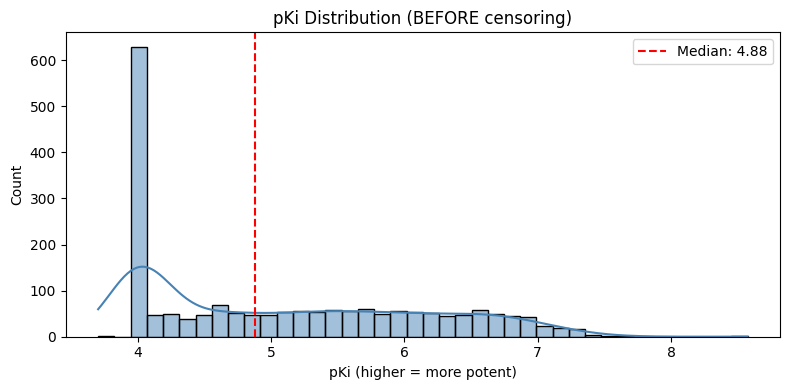


⚠️  Notice the spike at low pKi values — these are censored measurements!


In [5]:
# ============================================================================
# VISUALIZATION FUNCTION
# ============================================================================

def plot_pki_distribution(df: pd.DataFrame, title_suffix: str = "") -> None:
    """Plot the distribution of pKi values."""
    plt.figure(figsize=(8, 4))
    sns.histplot(df["pKi"], bins=40, kde=True, color="steelblue")
    plt.xlabel("pKi (higher = more potent)")
    plt.ylabel("Count")
    plt.title(f"pKi Distribution {title_suffix}")
    plt.axvline(df["pKi"].median(), color="red", linestyle="--", label=f"Median: {df['pKi'].median():.2f}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# Plot BEFORE removing censored values
plot_pki_distribution(df, "(BEFORE censoring)")
print(f"\n⚠️  Notice the spike at low pKi values — these are censored measurements!")

[INFO] Removed 582 censored molecules (IC50 > 99.0 μM)
[INFO] Remaining: 1342 molecules
[INFO] Successfully parsed 1342 molecules


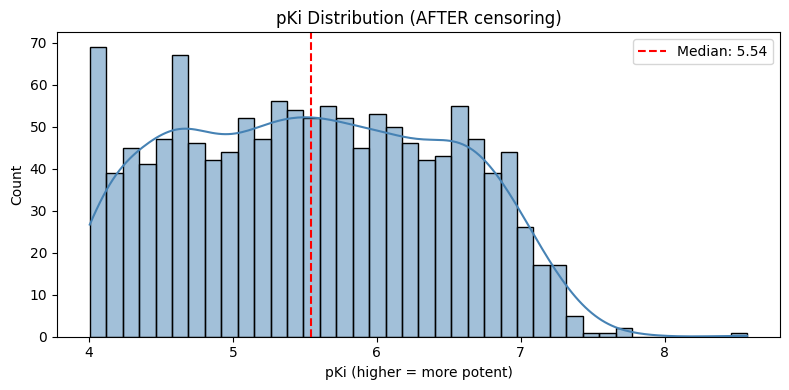


📊 Dataset Summary:
           pKi       MW     logP      HBD      HBA
count  1342.00  1342.00  1342.00  1342.00  1342.00
mean      5.55   424.79     3.73     1.30     4.48
std       0.92    86.48     1.05     0.79     1.58
min       4.00   237.65    -0.14     0.00     1.00
25%       4.76   353.81     3.14     1.00     3.00
50%       5.54   427.94     3.79     1.00     4.00
75%       6.30   493.27     4.38     2.00     5.00
max       8.57   865.69     7.07     9.00    19.00


In [6]:
# ============================================================================
# REMOVE CENSORED MEASUREMENTS AND FINALIZE DATA
# ============================================================================

# Step 3: Remove censored compounds
df = remove_censored_measurements(df, threshold=IC50_CENSOR_THRESHOLD)

# Step 4: Parse SMILES to RDKit molecules
df = smiles_to_mol(df)

# Step 5: Add basic descriptors
df = add_basic_descriptors(df)

# Plot AFTER censoring
plot_pki_distribution(df, "(AFTER censoring)")

# Show basic statistics
print("\n📊 Dataset Summary:")
print(df[["pKi", "MW", "logP", "HBD", "HBA"]].describe().round(2))

## 3. Molecular Fingerprints & Chemical Space Visualization

### Morgan Fingerprints (ECFP)

Morgan fingerprints encode circular substructures around each atom:
- **Radius 2** captures atom environments up to 2 bonds away (similar to ECFP4)
- Each substructure is hashed to a bit position in a fixed-length vector
- Similarity between molecules is measured using **Tanimoto coefficient**

### UMAP Projection

UMAP (Uniform Manifold Approximation and Projection) reduces the 2048-dimensional fingerprint space to 2D for visualization:
- Uses Jaccard distance (equivalent to 1 - Tanimoto for binary vectors)
- Preserves local neighborhood structure
- Reveals clusters of similar molecules

In [7]:
# ============================================================================
# FINGERPRINT & UMAP FUNCTIONS
# ============================================================================

def compute_fingerprints(df: pd.DataFrame) -> list:
    """Compute Morgan fingerprints for all molecules."""
    fps = [
        AllChem.GetMorganFingerprintAsBitVect(mol, FP_RADIUS, nBits=FP_BITS)
        for mol in df["mol"]
    ]
    print(f"[INFO] Computed {len(fps)} fingerprints (radius={FP_RADIUS}, bits={FP_BITS})")
    return fps


def fingerprints_to_array(fps: list) -> np.ndarray:
    """Convert RDKit fingerprints to numpy array."""
    return np.array([np.array(fp) for fp in fps])


def umap_projection(fps: list) -> np.ndarray:
    """Project fingerprints to 2D using UMAP."""
    X = fingerprints_to_array(fps)
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        metric="jaccard",
        random_state=RANDOM_SEED,
    )
    print("[INFO] Running UMAP projection...")
    return reducer.fit_transform(X)


def plot_umap(emb: np.ndarray, values: np.ndarray, title: str) -> None:
    """Plot UMAP embedding colored by a value (e.g., pKi)."""
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(emb[:, 0], emb[:, 1], c=values, cmap="viridis", s=12, alpha=0.7)
    plt.colorbar(sc, label="pKi")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title(title)
    plt.tight_layout()
    plt.show()

[INFO] Computed 1342 fingerprints (radius=2, bits=2048)


[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerator
[11:28:51] DEPRECATION WARNING: please use MorganGenerat

[INFO] Running UMAP projection...


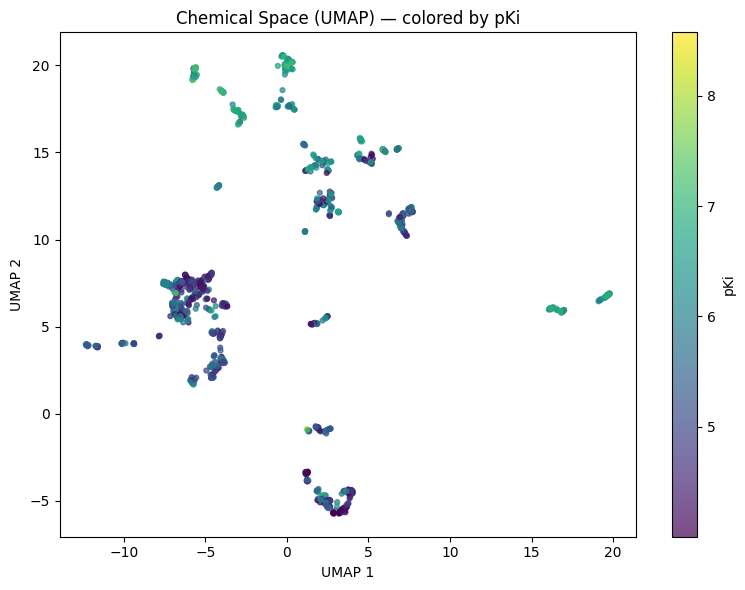


🔍 Observations:
   - Molecules cluster by structural similarity
   - Activity (color) often varies smoothly within clusters
   - BUT some nearby molecules have very different activities → Activity Cliffs!


In [8]:
# ============================================================================
# COMPUTE FINGERPRINTS AND VISUALIZE CHEMICAL SPACE
# ============================================================================

# Compute fingerprints
fps = compute_fingerprints(df)

# UMAP projection
emb = umap_projection(fps)

# Visualize
plot_umap(emb, df["pKi"].values, "Chemical Space (UMAP) — colored by pKi")

print("\n🔍 Observations:")
print("   - Molecules cluster by structural similarity")
print("   - Activity (color) often varies smoothly within clusters")
print("   - BUT some nearby molecules have very different activities → Activity Cliffs!")

## 4. Activity Cliffs

### What are Activity Cliffs?

An **activity cliff** is a pair of molecules that are:
1. **Structurally very similar** (high Tanimoto similarity, e.g., >0.95)
2. **Dramatically different in activity** (large ΔpKi, e.g., >2.0 units = 100× difference in potency)

### Why do Activity Cliffs Matter?

- They reveal **SAR (Structure-Activity Relationship)** hotspots
- Small chemical changes can have huge biological effects
- They are **notoriously difficult for ML models** to predict
- A model that memorizes training data will fail on cliffs in the test set

In [9]:
# ============================================================================
# ACTIVITY CLIFF DETECTION
# ============================================================================

def find_activity_cliffs(
    df: pd.DataFrame, 
    fps: list, 
    sim_threshold: float = 0.95, 
    delta_pki_threshold: float = 2.0
) -> list:
    """
    Find pairs of molecules that are structurally similar but have very different activities.
    
    Args:
        df: DataFrame with pKi values
        fps: List of fingerprints
        sim_threshold: Minimum Tanimoto similarity to be considered "similar"
        delta_pki_threshold: Minimum pKi difference to be considered a "cliff"
    
    Returns:
        List of tuples: (idx_i, idx_j, similarity, delta_pKi)
    """
    cliffs = []
    
    for i in range(len(df)):
        # Compute similarity of molecule i to all others
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps)
        
        for j, sim in enumerate(sims):
            if j <= i:  # Avoid duplicates and self-comparison
                continue
            if sim >= sim_threshold:
                delta = abs(df.iloc[i]["pKi"] - df.iloc[j]["pKi"])
                if delta >= delta_pki_threshold:
                    cliffs.append((i, j, sim, delta))
    
    print(f"[INFO] Found {len(cliffs)} activity cliffs")
    print(f"       (Tanimoto ≥ {sim_threshold}, ΔpKi ≥ {delta_pki_threshold})")
    return cliffs


# Find activity cliffs
cliffs = find_activity_cliffs(df, fps, sim_threshold=0.95, delta_pki_threshold=2.0)

[INFO] Found 51 activity cliffs
       (Tanimoto ≥ 0.95, ΔpKi ≥ 2.0)


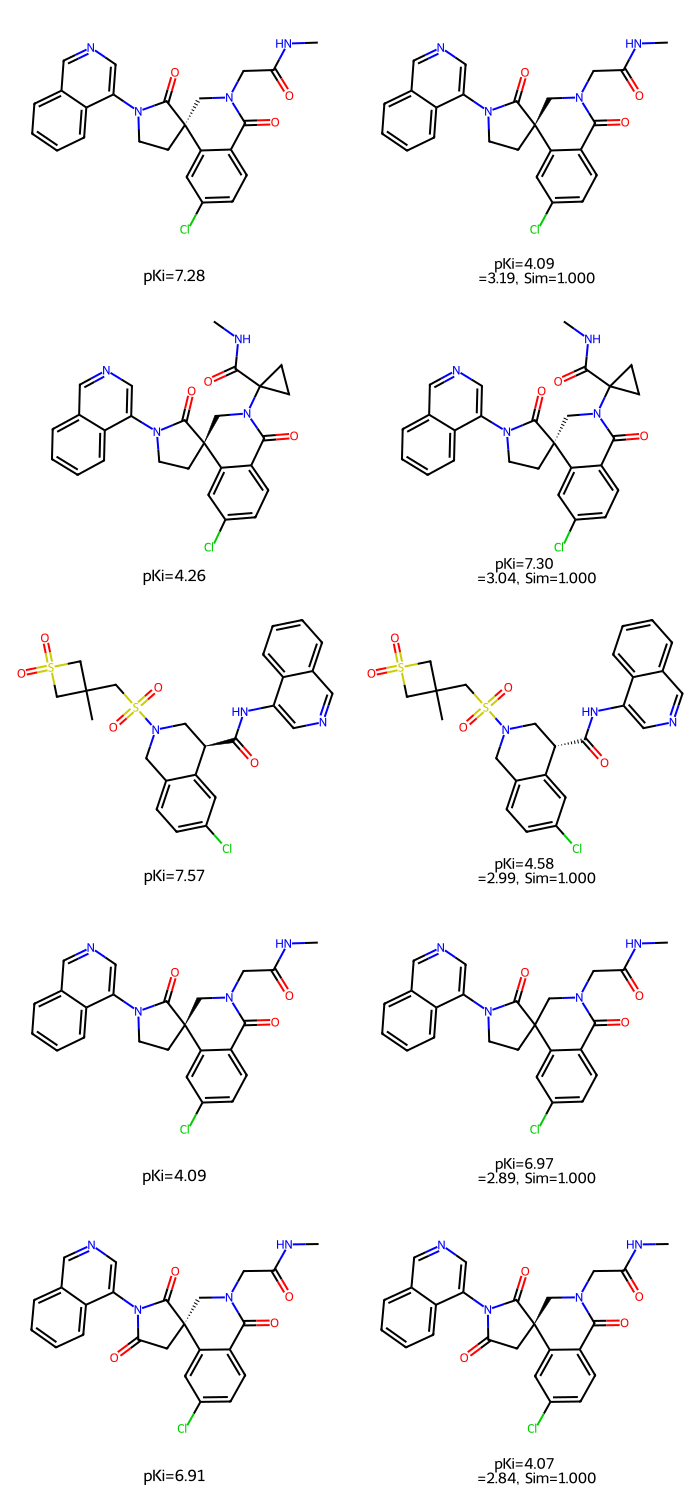


🎯 Each row shows a cliff pair:
   - Left and right molecules are >95% similar
   - But their activities differ by >100× (ΔpKi > 2)


In [10]:
# ============================================================================
# VISUALIZE ACTIVITY CLIFFS
# ============================================================================

def visualize_activity_cliffs(df: pd.DataFrame, cliffs: list, n_pairs: int = 5):
    """Display pairs of molecules that form activity cliffs."""
    if len(cliffs) == 0:
        print("No activity cliffs found!")
        return
    
    # Sort by delta_pKi (most dramatic cliffs first)
    cliffs_sorted = sorted(cliffs, key=lambda x: x[3], reverse=True)[:n_pairs]
    
    mols = []
    legends = []
    
    for i, j, sim, delta in cliffs_sorted:
        mols.extend([df.iloc[i]["mol"], df.iloc[j]["mol"]])
        legends.extend([
            f"pKi={df.iloc[i]['pKi']:.2f}",
            f"pKi={df.iloc[j]['pKi']:.2f}\nΔ={delta:.2f}, Sim={sim:.3f}"
        ])
    
    # Draw molecules in a grid
    img = MolsToGridImage(
        mols, 
        molsPerRow=2, 
        subImgSize=(350, 300),
        legends=legends
    )
    display(img)
    
    print("\n🎯 Each row shows a cliff pair:")
    print("   - Left and right molecules are >95% similar")
    print("   - But their activities differ by >100× (ΔpKi > 2)")


visualize_activity_cliffs(df, cliffs, n_pairs=5)

## 5. Scaffold Analysis

### Murcko Scaffolds

The **Murcko scaffold** is the core ring system of a molecule (stripping side chains):
- Useful for grouping molecules by chemical series
- Important for **scaffold-based splitting** — ensuring the model sees novel chemotypes at test time

### Why Scaffold Splitting?

Random splits often leak information:
- Training and test sets may contain molecules from the same series
- The model can "cheat" by memorizing series-level patterns
- This leads to **overly optimistic** performance estimates

In [11]:
# ============================================================================
# SCAFFOLD ANALYSIS
# ============================================================================

def compute_scaffolds(df: pd.DataFrame) -> pd.DataFrame:
    """Extract Murcko scaffolds for all molecules."""
    df["scaffold"] = df["mol"].apply(
        lambda m: Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(m))
    )
    return df


# Compute scaffolds
df = compute_scaffolds(df)

# Statistics
n_scaffolds = df["scaffold"].nunique()
print(f"[INFO] Found {n_scaffolds} unique scaffolds among {len(df)} molecules")
print(f"       Average molecules per scaffold: {len(df) / n_scaffolds:.1f}")

# Show most common scaffolds
print("\n📊 Top 5 most common scaffolds:")
print(df["scaffold"].value_counts().head())

[INFO] Found 678 unique scaffolds among 1342 molecules
       Average molecules per scaffold: 2.0

📊 Top 5 most common scaffolds:
scaffold
O=C(Cc1ccccc1)Nc1cncc2ccccc12             90
O=C(Nc1cncc2ccccc12)C1CCOc2ccccc21        76
O=C(Nc1cncc2ccccc12)C1CNCc2ccccc21        48
O=C1NCC(C(=O)Nc2cncc3ccccc23)c2ccccc21    43
O=C(Cc1ccccc1)Nc1cccnc1                   25
Name: count, dtype: int64


## 6. Dataset Splitting Strategies

We compare **4 different splitting strategies** to understand how the choice affects model evaluation:

### 1. Random Split
- Molecules are randomly assigned to train/test
- **Problem**: Similar molecules (even from the same series) can appear in both sets
- **Result**: Overly optimistic performance

### 2. Scaffold Split
- Entire scaffolds (chemical series) go to either train OR test
- **Effect**: Tests generalization to new chemotypes
- **Result**: More realistic but still may group similar scaffolds

### 3. Butina Clustering Split
- Clusters molecules by Tanimoto similarity using Butina algorithm
- Entire clusters go to train or test
- **Effect**: Ensures structural novelty in test set
- **Result**: Harder than scaffold split

### 4. UMAP-based Split
- Uses UMAP 2D projection to identify spatially separated regions
- Test set comes from distinct regions of chemical space
- **Effect**: Maximum structural novelty
- **Result**: The hardest, most realistic test of generalization

In [12]:
# ============================================================================
# SPLITTING FUNCTIONS
# ============================================================================

def random_split(X: np.ndarray, y: np.ndarray, test_size: float = 0.2):
    """Standard random train/test split."""
    return train_test_split(X, y, test_size=test_size, random_state=RANDOM_SEED)


def scaffold_split(df: pd.DataFrame, test_size: float = 0.2):
    """
    Split by scaffold: entire chemical series go to train or test.
    Returns boolean masks for train and test sets.
    """
    scaffolds = df["scaffold"].unique()
    np.random.shuffle(scaffolds)
    
    n_test = int(test_size * len(scaffolds))
    test_scaffolds = set(scaffolds[:n_test])
    
    test_mask = df["scaffold"].isin(test_scaffolds)
    train_mask = ~test_mask
    
    return train_mask.values, test_mask.values


def butina_split(fps: list, cutoff: float = 0.6, test_size: float = 0.3):
    """
    Cluster molecules using Butina algorithm, then split by clusters.
    Returns boolean masks for train and test sets.
    """
    # Compute pairwise distances (as required by Butina)
    n = len(fps)
    dists = []
    for i in range(1, n):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1 - s for s in sims])
    
    # Cluster
    clusters = Butina.ClusterData(dists, n, cutoff, isDistData=True)
    clusters = list(clusters)
    np.random.shuffle(clusters)
    
    # Assign clusters to test set
    n_test_clusters = int(test_size * len(clusters))
    test_clusters = clusters[:n_test_clusters]
    
    test_idx = np.zeros(n, dtype=bool)
    for cluster in test_clusters:
        test_idx[list(cluster)] = True
    
    return ~test_idx, test_idx


def umap_split(emb: np.ndarray, test_size: float = 0.2, n_regions: int = 10):
    """
    Split by UMAP regions: divide 2D space into grid cells, 
    assign entire cells to train or test.
    
    This ensures test molecules come from distinct regions of chemical space.
    """
    n = len(emb)
    
    # Create grid-based regions
    x_bins = np.linspace(emb[:, 0].min(), emb[:, 0].max(), n_regions + 1)
    y_bins = np.linspace(emb[:, 1].min(), emb[:, 1].max(), n_regions + 1)
    
    # Assign each point to a region
    x_idx = np.digitize(emb[:, 0], x_bins[:-1]) - 1
    y_idx = np.digitize(emb[:, 1], y_bins[:-1]) - 1
    region_ids = x_idx * n_regions + y_idx
    
    # Get unique regions and shuffle
    unique_regions = np.unique(region_ids)
    np.random.shuffle(unique_regions)
    
    # Assign regions to test set until we reach target size
    test_mask = np.zeros(n, dtype=bool)
    current_test_size = 0
    target_test_size = int(test_size * n)
    
    for region in unique_regions:
        if current_test_size >= target_test_size:
            break
        region_mask = region_ids == region
        test_mask |= region_mask
        current_test_size = test_mask.sum()
    
    return ~test_mask, test_mask


print("✅ All splitting functions defined")

✅ All splitting functions defined


## 7. QSAR Modeling

### Model: XGBoost Regressor

We use **XGBoost** (Gradient Boosted Trees) for QSAR modeling:
- Works well with sparse fingerprint features
- Handles non-linear relationships
- Fast training on medium-sized datasets

### Evaluation Metrics

1. **RMSE** (Root Mean Squared Error): Measures prediction accuracy in pKi units
2. **Spearman ρ** (Rank Correlation): Measures ability to rank compounds correctly
   - More important for virtual screening where we care about ranking, not absolute values

In [13]:
# ============================================================================
# QSAR MODELING FUNCTIONS
# ============================================================================

def train_xgb(X_train: np.ndarray, y_train: np.ndarray) -> XGBRegressor:
    """Train an XGBoost regressor."""
    model = XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        random_state=RANDOM_SEED,
        verbosity=0  # Suppress warnings
    )
    model.fit(X_train, y_train)
    return model


def evaluate_model(model: XGBRegressor, X_test: np.ndarray, y_test: np.ndarray) -> dict:
    """Evaluate model and return metrics."""
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Manual RMSE calculation
    rho, pval = spearmanr(y_test, y_pred)
    
    return {
        "rmse": rmse,
        "spearman_rho": rho,
        "y_pred": y_pred,
        "y_test": y_test
    }


def plot_predictions(y_test: np.ndarray, y_pred: np.ndarray, title: str) -> None:
    """Plot predicted vs experimental values."""
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test, y_pred, alpha=0.5, s=20)
    plt.xlabel("Experimental pKi")
    plt.ylabel("Predicted pKi")
    plt.title(title)
    
    # Add diagonal line
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    plt.plot(lims, lims, "r--", alpha=0.8, label="Perfect prediction")
    plt.legend()
    plt.tight_layout()
    plt.show()


print("✅ Modeling functions defined")

✅ Modeling functions defined


In [14]:
# ============================================================================
# COMPARE ALL SPLITTING STRATEGIES
# ============================================================================

# Prepare feature matrix and target
X = fingerprints_to_array(fps)
y = df["pKi"].values

print("=" * 70)
print("COMPARING 4 SPLITTING STRATEGIES")
print("=" * 70)

# Store results for comparison
results = {}

# -------------------------------------------------------------------------
# 1. RANDOM SPLIT
# -------------------------------------------------------------------------
print("\n📊 1. RANDOM SPLIT")
print("-" * 40)

X_train, X_test, y_train, y_test = random_split(X, y)
print(f"   Train: {len(y_train)}, Test: {len(y_test)}")

model_random = train_xgb(X_train, y_train)
res_random = evaluate_model(model_random, X_test, y_test)

print(f"   RMSE: {res_random['rmse']:.3f}")
print(f"   Spearman ρ: {res_random['spearman_rho']:.3f}")

results["Random"] = res_random

# -------------------------------------------------------------------------
# 2. SCAFFOLD SPLIT
# -------------------------------------------------------------------------
print("\n📊 2. SCAFFOLD SPLIT")
print("-" * 40)

train_mask, test_mask = scaffold_split(df)
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
print(f"   Train: {len(y_train)}, Test: {len(y_test)}")

model_scaffold = train_xgb(X_train, y_train)
res_scaffold = evaluate_model(model_scaffold, X_test, y_test)

print(f"   RMSE: {res_scaffold['rmse']:.3f}")
print(f"   Spearman ρ: {res_scaffold['spearman_rho']:.3f}")

results["Scaffold"] = res_scaffold

# -------------------------------------------------------------------------
# 3. BUTINA CLUSTERING SPLIT
# -------------------------------------------------------------------------
print("\n📊 3. BUTINA CLUSTERING SPLIT")
print("-" * 40)

train_mask, test_mask = butina_split(fps, cutoff=0.6)
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
print(f"   Train: {len(y_train)}, Test: {len(y_test)}")

model_butina = train_xgb(X_train, y_train)
res_butina = evaluate_model(model_butina, X_test, y_test)

print(f"   RMSE: {res_butina['rmse']:.3f}")
print(f"   Spearman ρ: {res_butina['spearman_rho']:.3f}")

results["Butina"] = res_butina

# -------------------------------------------------------------------------
# 4. UMAP-BASED SPLIT
# -------------------------------------------------------------------------
print("\n📊 4. UMAP-BASED SPLIT")
print("-" * 40)

train_mask, test_mask = umap_split(emb, n_regions=8)
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
print(f"   Train: {len(y_train)}, Test: {len(y_test)}")

model_umap = train_xgb(X_train, y_train)
res_umap = evaluate_model(model_umap, X_test, y_test)

print(f"   RMSE: {res_umap['rmse']:.3f}")
print(f"   Spearman ρ: {res_umap['spearman_rho']:.3f}")

results["UMAP"] = res_umap

print("\n" + "=" * 70)

COMPARING 4 SPLITTING STRATEGIES

📊 1. RANDOM SPLIT
----------------------------------------
   Train: 1073, Test: 269
   RMSE: 0.626
   Spearman ρ: 0.739

📊 2. SCAFFOLD SPLIT
----------------------------------------
   Train: 1100, Test: 242
   RMSE: 0.701
   Spearman ρ: 0.711

📊 3. BUTINA CLUSTERING SPLIT
----------------------------------------
   Train: 1131, Test: 211
   RMSE: 0.630
   Spearman ρ: 0.721

📊 4. UMAP-BASED SPLIT
----------------------------------------
   Train: 1000, Test: 342
   RMSE: 0.529
   Spearman ρ: 0.769



In [15]:
# ============================================================================
# RESULTS COMPARISON
# ============================================================================

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    "Split": list(results.keys()),
    "RMSE": [results[k]["rmse"] for k in results],
    "Spearman ρ": [results[k]["spearman_rho"] for k in results]
}).sort_values("RMSE", ascending=False)

print("\n📊 RESULTS SUMMARY (sorted by difficulty - hardest first)")
print("=" * 60)
print(comparison_df.to_string(index=False))
print("=" * 60)

# Identify the hardest split
hardest = comparison_df.iloc[0]["Split"]
easiest = comparison_df.iloc[-1]["Split"]

print(f"\n🔴 HARDEST split: {hardest} (RMSE = {comparison_df.iloc[0]['RMSE']:.3f})")
print(f"🟢 EASIEST split: {easiest} (RMSE = {comparison_df.iloc[-1]['RMSE']:.3f})")

# Calculate performance gap
gap_rmse = comparison_df.iloc[0]["RMSE"] - comparison_df.iloc[-1]["RMSE"]
gap_rho = comparison_df.iloc[-1]["Spearman ρ"] - comparison_df.iloc[0]["Spearman ρ"]

print(f"\n⚠️  Performance gap:")
print(f"   RMSE difference: {gap_rmse:.3f} pKi units")
print(f"   Spearman ρ difference: {gap_rho:.3f}")


📊 RESULTS SUMMARY (sorted by difficulty - hardest first)
   Split     RMSE  Spearman ρ
Scaffold 0.701387    0.710571
  Butina 0.630436    0.720763
  Random 0.625556    0.739393
    UMAP 0.529044    0.769401

🔴 HARDEST split: Scaffold (RMSE = 0.701)
🟢 EASIEST split: UMAP (RMSE = 0.529)

⚠️  Performance gap:
   RMSE difference: 0.172 pKi units
   Spearman ρ difference: 0.059


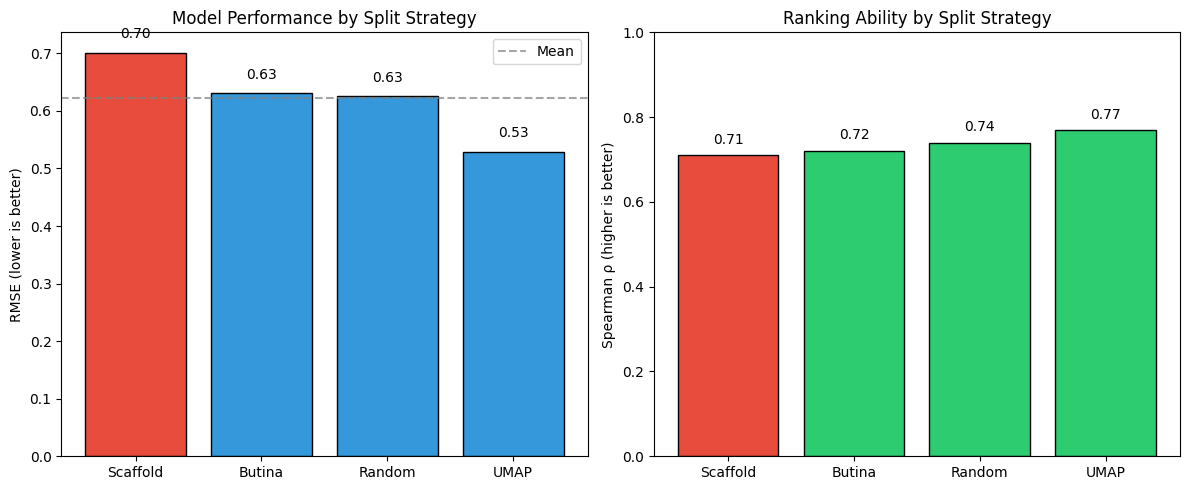

In [16]:
# ============================================================================
# VISUALIZE COMPARISON
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: RMSE comparison (bar chart)
ax1 = axes[0]
colors = ['#e74c3c' if s == hardest else '#3498db' for s in comparison_df["Split"]]
bars = ax1.bar(comparison_df["Split"], comparison_df["RMSE"], color=colors, edgecolor='black')
ax1.set_ylabel("RMSE (lower is better)")
ax1.set_title("Model Performance by Split Strategy")
ax1.axhline(comparison_df["RMSE"].mean(), color='gray', linestyle='--', alpha=0.7, label='Mean')
ax1.legend()

# Add value labels on bars
for bar, val in zip(bars, comparison_df["RMSE"]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=10)

# Plot 2: Spearman correlation comparison
ax2 = axes[1]
colors = ['#e74c3c' if s == hardest else '#2ecc71' for s in comparison_df["Split"]]
bars = ax2.bar(comparison_df["Split"], comparison_df["Spearman ρ"], color=colors, edgecolor='black')
ax2.set_ylabel("Spearman ρ (higher is better)")
ax2.set_title("Ranking Ability by Split Strategy")
ax2.set_ylim(0, 1)

# Add value labels on bars
for bar, val in zip(bars, comparison_df["Spearman ρ"]):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

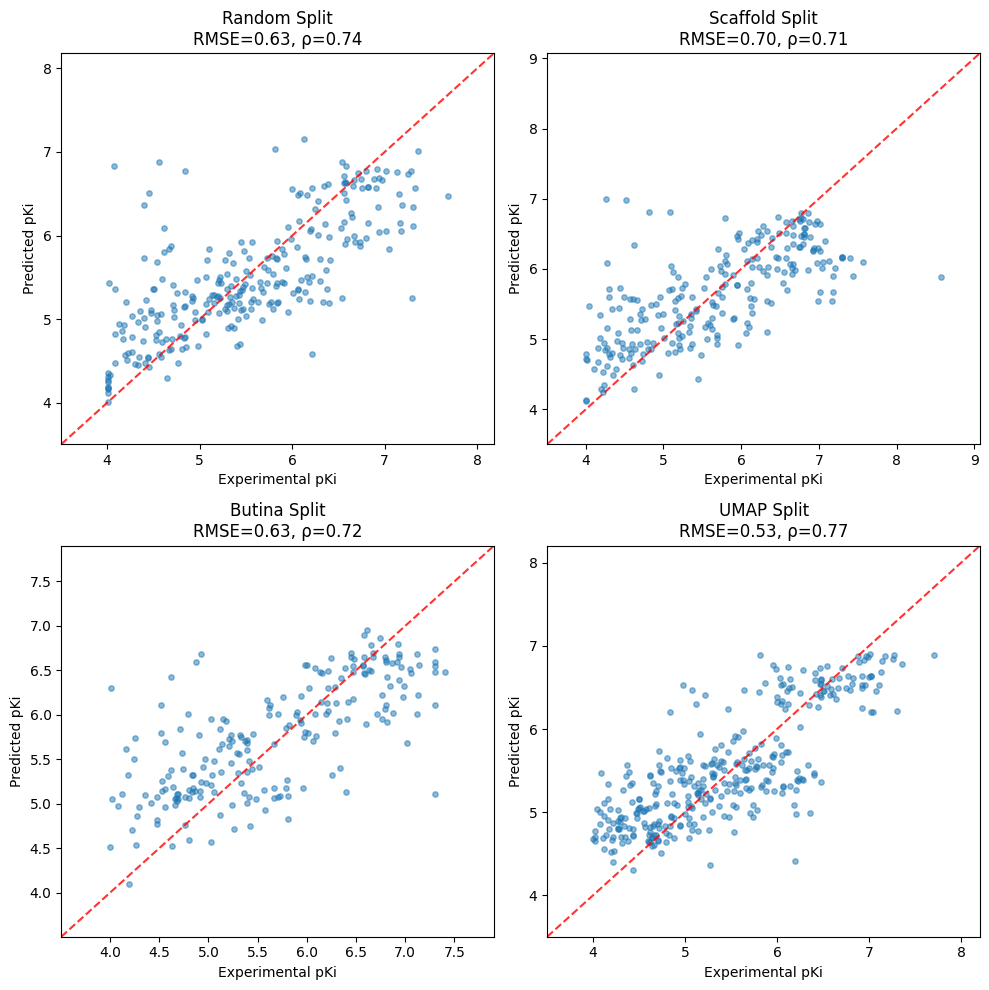


🔍 Observations:
   - Random split shows the tightest correlation (but this is misleading!)
   - Harder splits show more scatter, especially for novel chemotypes
   - The model struggles when test molecules are structurally different from training


In [17]:
# ============================================================================
# PREDICTION SCATTER PLOTS FOR EACH SPLIT
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for ax, (name, res) in zip(axes, results.items()):
    y_test = res["y_test"]
    y_pred = res["y_pred"]
    
    ax.scatter(y_test, y_pred, alpha=0.5, s=15)
    
    # Diagonal line
    lims = [min(y_test.min(), y_pred.min()) - 0.5, max(y_test.max(), y_pred.max()) + 0.5]
    ax.plot(lims, lims, "r--", alpha=0.8)
    
    ax.set_xlabel("Experimental pKi")
    ax.set_ylabel("Predicted pKi")
    ax.set_title(f"{name} Split\nRMSE={res['rmse']:.2f}, ρ={res['spearman_rho']:.2f}")
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.tight_layout()
plt.show()

print("\n🔍 Observations:")
print("   - Random split shows the tightest correlation (but this is misleading!)")
print("   - Harder splits show more scatter, especially for novel chemotypes")
print("   - The model struggles when test molecules are structurally different from training")

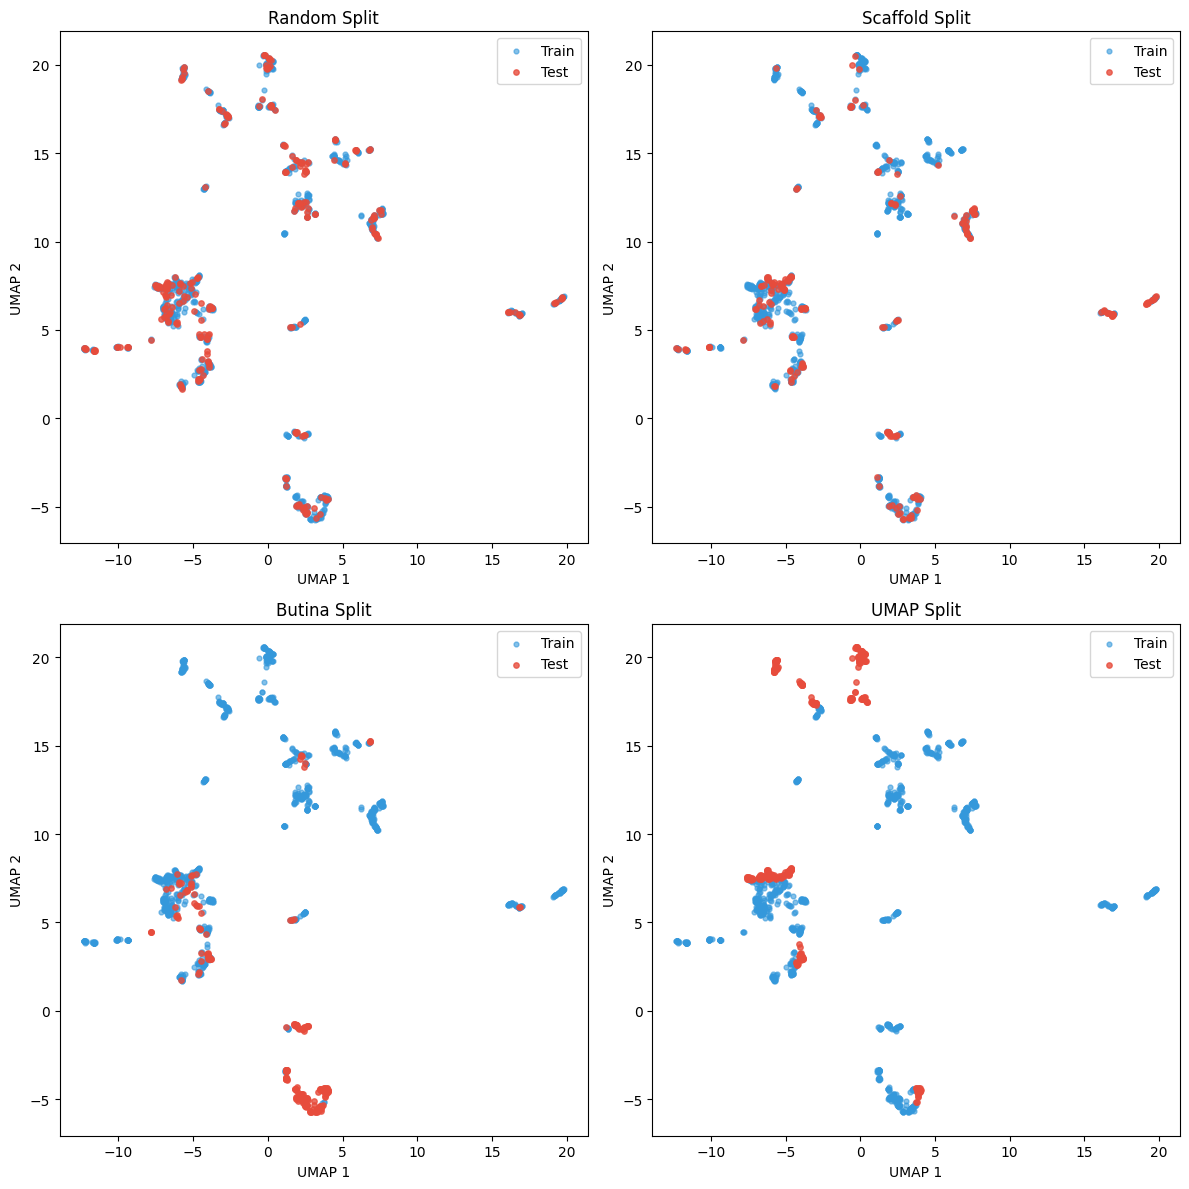


🔍 Notice how different splits distribute test molecules:
   - Random: test points scattered throughout (similar to training)
   - Scaffold/Butina: test points in localized clusters
   - UMAP: test points in distinct regions of chemical space


In [18]:
# ============================================================================
# VISUALIZE SPLITS IN CHEMICAL SPACE (UMAP)
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

split_functions = [
    ("Random", lambda: random_split(X, y)),
    ("Scaffold", lambda: scaffold_split(df)),
    ("Butina", lambda: butina_split(fps, cutoff=0.6)),
    ("UMAP", lambda: umap_split(emb, n_regions=8))
]

for ax, (name, split_fn) in zip(axes, split_functions):
    # Get split masks
    if name == "Random":
        # Random split returns data, not masks - we need to recreate masks
        X_train, X_test, y_train, y_test = split_fn()
        # We can't easily show this in UMAP space without indices
        # So we'll just show a random 20% as "test"
        test_mask = np.zeros(len(df), dtype=bool)
        test_idx = np.random.choice(len(df), size=int(0.2*len(df)), replace=False)
        test_mask[test_idx] = True
    else:
        train_mask, test_mask = split_fn()
    
    # Plot
    ax.scatter(emb[~test_mask, 0], emb[~test_mask, 1], 
               c='#3498db', s=12, alpha=0.6, label='Train')
    ax.scatter(emb[test_mask, 0], emb[test_mask, 1], 
               c='#e74c3c', s=15, alpha=0.8, label='Test')
    
    ax.set_title(f"{name} Split")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\n🔍 Notice how different splits distribute test molecules:")
print("   - Random: test points scattered throughout (similar to training)")
print("   - Scaffold/Butina: test points in localized clusters")
print("   - UMAP: test points in distinct regions of chemical space")

## 8. Model Explainability

### Similarity Maps

We can visualize which atoms contribute most to the model's prediction using **similarity maps**:
- Red regions: increase predicted activity
- Blue regions: decrease predicted activity

This helps understand:
- What structural features the model learned
- Why certain predictions are wrong
- Whether the model is learning chemically meaningful patterns

🔬 Explaining predictions for selected molecules:
   (Using model trained on random split)

Most potent molecule (pKi = 8.57):


[11:29:57] DEPRECATION WARNING: please use MorganGenerator


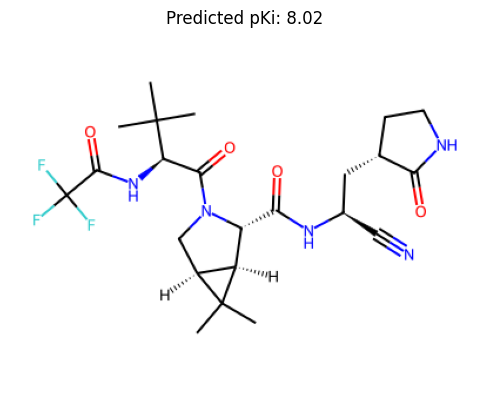


Least potent molecule (pKi = 4.00):


[11:29:58] DEPRECATION WARNING: please use MorganGenerator


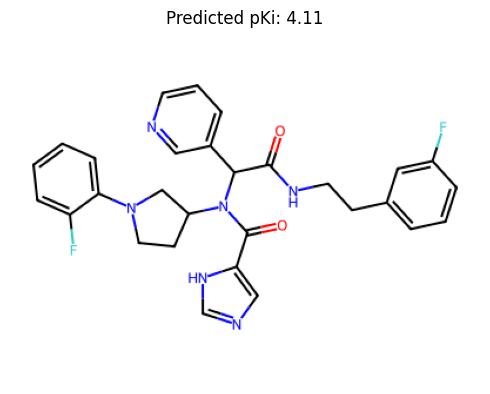

In [19]:
# ============================================================================
# MODEL EXPLAINABILITY
# ============================================================================

def explain_molecule(mol, model, title=""):
    """Generate a similarity map showing which atoms drive the prediction."""
    def get_fp(m, atom_idx=-1):
        """Get fingerprint, optionally with a specific atom removed."""
        if atom_idx >= 0:
            # Get the atom environment contribution
            info = {}
            fp = AllChem.GetMorganFingerprintAsBitVect(m, FP_RADIUS, nBits=FP_BITS, bitInfo=info)
        else:
            fp = AllChem.GetMorganFingerprintAsBitVect(m, FP_RADIUS, nBits=FP_BITS)
        return np.array(fp)
    
    def predictor(m):
        fp = get_fp(m)
        return model.predict(fp.reshape(1, -1))[0]
    
    # Calculate atom contributions using Morgan fingerprint similarity map
    try:
        # Try newer RDKit API (2023+)
        from rdkit.Chem.Draw.SimilarityMaps import GetSimilarityMapForFingerprint
        
        def fp_func(m, idx):
            """Function to generate fingerprint for similarity map."""
            return AllChem.GetMorganFingerprint(m, FP_RADIUS, fromAtoms=[idx])
        
        fig = SimilarityMaps.GetSimilarityMapForFingerprint(
            mol, 
            fp_func,
            lambda x: model.predict(fingerprints_to_array([AllChem.GetMorganFingerprintAsBitVect(x, FP_RADIUS, nBits=FP_BITS)]))[0]
        )
        if title:
            plt.title(title)
        plt.show()
        
    except Exception as e:
        # Fallback: just show the molecule with prediction
        pred = predictor(mol)
        
        # Draw molecule
        from rdkit.Chem import Draw
        img = Draw.MolToImage(mol, size=(400, 300))
        
        plt.figure(figsize=(5, 4))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title}\nPredicted pKi: {pred:.2f}" if title else f"Predicted pKi: {pred:.2f}")
        plt.tight_layout()
        plt.show()


# Use the model trained on random split (most optimistic) for explainability
print("🔬 Explaining predictions for selected molecules:")
print("   (Using model trained on random split)\n")

# Find molecules with highest and lowest pKi
idx_best = df["pKi"].idxmax()
idx_worst = df["pKi"].idxmin()

print(f"Most potent molecule (pKi = {df.loc[idx_best, 'pKi']:.2f}):")
explain_molecule(df.loc[idx_best, "mol"], model_random)

print(f"\nLeast potent molecule (pKi = {df.loc[idx_worst, 'pKi']:.2f}):")
explain_molecule(df.loc[idx_worst, "mol"], model_random)

🔍 Molecules with HIGHEST prediction error (UMAP split):

#1: Error = 1.78 pKi units
    Experimental: 6.20, Predicted: 4.41


[11:29:58] DEPRECATION WARNING: please use MorganGenerator


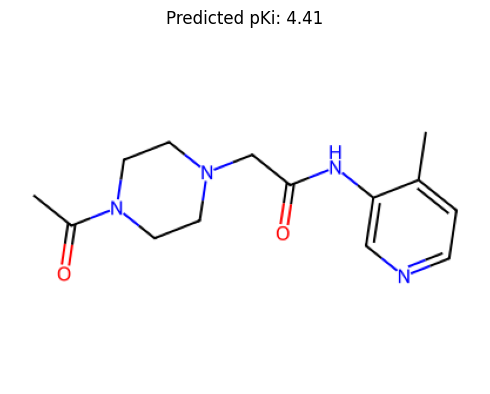


#2: Error = 1.56 pKi units
    Experimental: 4.98, Predicted: 6.54


[11:29:58] DEPRECATION WARNING: please use MorganGenerator


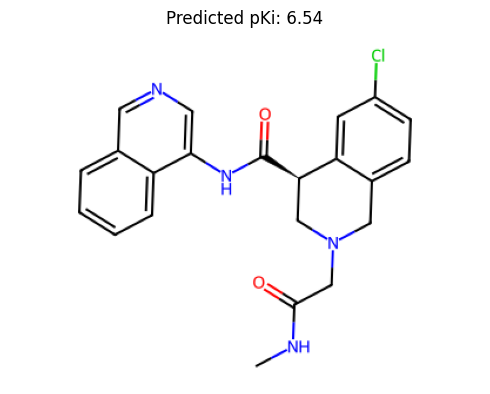


#3: Error = 1.40 pKi units
    Experimental: 5.07, Predicted: 6.48


[11:29:58] DEPRECATION WARNING: please use MorganGenerator


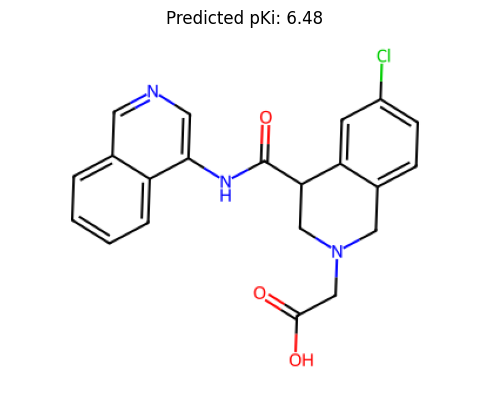


💡 High-error molecules are often:
   - Activity cliffs (similar to training molecules but different activity)
   - Novel scaffolds not seen during training
   - Compounds with unusual substituents


In [20]:
# ============================================================================
# ANALYZE HIGH-ERROR PREDICTIONS
# ============================================================================

# Use stored results from the UMAP split (already computed in Cell 21)
y_test_umap = results["UMAP"]["y_test"]
y_pred_umap = results["UMAP"]["y_pred"]

# Calculate errors
errors = np.abs(y_test_umap - y_pred_umap)
error_order = np.argsort(errors)[::-1]  # Highest error first

print("🔍 Molecules with HIGHEST prediction error (UMAP split):")
print("=" * 60)

# Find molecules that were in the test set by matching pKi values
# (since we stored y_test, we can find the original indices)
test_pki_values = set(y_test_umap)

# Show top 3 worst predictions
for rank, idx in enumerate(error_order[:3]):
    exp_val = y_test_umap[idx]
    pred_val = y_pred_umap[idx]
    error_val = errors[idx]
    
    # Find the molecule in df with this pKi value
    matching_idx = df[np.isclose(df["pKi"].values, exp_val, atol=1e-6)].index
    
    print(f"\n#{rank+1}: Error = {error_val:.2f} pKi units")
    print(f"    Experimental: {exp_val:.2f}, Predicted: {pred_val:.2f}")
    
    if len(matching_idx) > 0:
        mol_idx = matching_idx[0]
        explain_molecule(df.loc[mol_idx, "mol"], model_umap)
    else:
        print("    (Could not find matching molecule for visualization)")

print("\n💡 High-error molecules are often:")
print("   - Activity cliffs (similar to training molecules but different activity)")
print("   - Novel scaffolds not seen during training")
print("   - Compounds with unusual substituents")

## 9. Conclusions

### Key Takeaways

1. **Splitting strategy dramatically affects apparent model performance**
   - Random splits are overly optimistic
   - Structure-aware splits (scaffold, Butina, UMAP) give more realistic estimates

2. **Activity cliffs are a fundamental challenge**
   - Small structural changes can cause large activity differences
   - Fingerprint-based models struggle with cliffs
   - This is a key limitation of 2D representations

3. **The "applicability domain" matters**
   - Models work best within the chemical space of training data
   - Predictions for novel chemotypes should be treated with caution

4. **Explainability helps build trust**
   - Similarity maps reveal what features drive predictions
   - High-error predictions often have interpretable explanations

### Recommendations for Real-World QSAR

- Always use **structure-aware splitting** for validation
- Report performance on multiple split types
- Be skeptical of models with very high random-split performance
- Consider the **applicability domain** when deploying models
- Use **ensemble methods** to estimate prediction uncertainty

In [21]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("=" * 70)
print("📋 FINAL SUMMARY")
print("=" * 70)

print(f"\n📊 Dataset: SARS-CoV-2 Mpro inhibitors")
print(f"   Molecules: {len(df)}")
print(f"   Unique scaffolds: {df['scaffold'].nunique()}")
print(f"   Activity cliffs: {len(cliffs)}")

print(f"\n🏆 SPLIT COMPARISON (ordered by difficulty):")
print("-" * 50)
for _, row in comparison_df.iterrows():
    marker = "🔴" if row["Split"] == hardest else "🟢" if row["Split"] == easiest else "🔵"
    print(f"   {marker} {row['Split']:12} RMSE={row['RMSE']:.3f}  ρ={row['Spearman ρ']:.3f}")

print(f"\n⚠️  KEY INSIGHT:")
print(f"   Using random split instead of {hardest} split would overestimate")
print(f"   model performance by {gap_rmse:.2f} RMSE units ({gap_rho:.2f} in Spearman ρ)")

print("\n✅ Laboratory complete!")
print("=" * 70)

📋 FINAL SUMMARY

📊 Dataset: SARS-CoV-2 Mpro inhibitors
   Molecules: 1342
   Unique scaffolds: 678
   Activity cliffs: 51

🏆 SPLIT COMPARISON (ordered by difficulty):
--------------------------------------------------
   🔴 Scaffold     RMSE=0.701  ρ=0.711
   🔵 Butina       RMSE=0.630  ρ=0.721
   🔵 Random       RMSE=0.626  ρ=0.739
   🟢 UMAP         RMSE=0.529  ρ=0.769

⚠️  KEY INSIGHT:
   Using random split instead of Scaffold split would overestimate
   model performance by 0.17 RMSE units (0.06 in Spearman ρ)

✅ Laboratory complete!
